**Load and Explore the Data**

In [ ]:
import pandas as pd

# Load the dataset
file_path = "MLE-Assignment.csv"  # Update the file path if necessary
df = pd.read_csv(file_path)

# Display basic info and first few rows
print("Dataset Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB

First 5 rows:
           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.67

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])


Missing Values:
 Series([], dtype: int64)


In [ ]:
# Summary statistics of the dataset
print("\nSummary Statistics:")
print(df.describe())

# Check for duplicate rows
duplicates = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicates)



Summary Statistics:
                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.443118    0.440761    0.433814    0.426122    0.418990    0.412432   
std      0.044719    0.045520    0.045764    0.046070    0.045405    0.044727   
min      0.311182    0.295321    0.284064    0.282054    0.296702    0.286860   
25%      0.410456    0.404310    0.397038    0.389029    0.382102    0.377157   
50%      0.449105    0.442651    0.434215    0.425074    0.417075    0.411872   
75%      0.480245    0.478822    0.473158    0.464947    0.459232    0.452198   
max      0.556287    0.530168    0.528774    0.533202    0.511909    0.501786   

                6           7           8           9  ...         439  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.405868    0.399815    0.394038    0.389664  ...    0.741255   
std      0.044528    0.0437

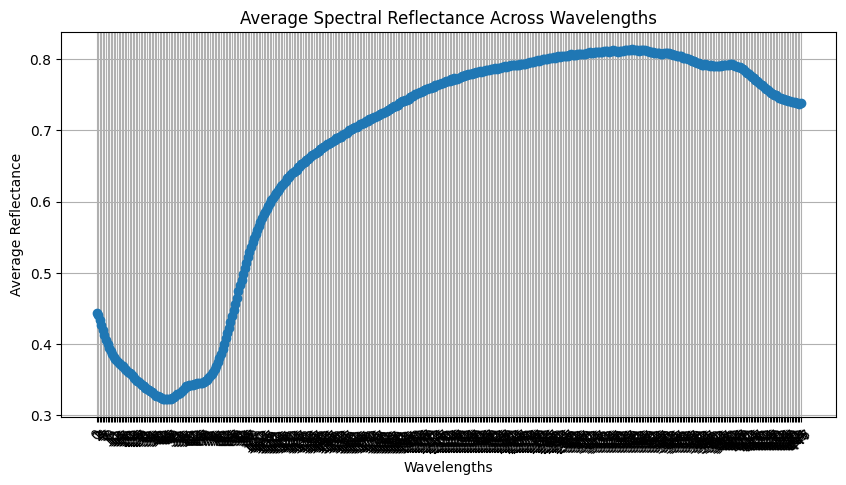

In [ ]:
import matplotlib.pyplot as plt

# Assuming the spectral reflectance features start from the 2nd column onward
wavelengths = df.columns[1:-1]  # Exclude first (ID) and last (target variable) columns

# Plot the average spectral reflectance across wavelengths
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, df[wavelengths].mean(), marker="o")
plt.xlabel("Wavelengths")
plt.ylabel("Average Reflectance")
plt.title("Average Spectral Reflectance Across Wavelengths")
plt.xticks(rotation=45)
plt.grid()
plt.show()


**Data Preprocessing**

In [ ]:
import numpy as np

# Select numeric columns only for imputation
numeric_cols = df.select_dtypes(include=np.number).columns
# Impute missing values with mean (or choose median) for numeric columns only
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select only spectral feature columns (excluding ID and target)
X = df.iloc[:, 1:-1]  # Features
y = df.iloc[:, -1]    # Target (DON concentration)

# Normalize the spectral data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

**Detect and Remove Outliers**

In [ ]:
import numpy as np

# Z-score method to detect outliers
z_scores = np.abs((X - X.mean()) / X.std())

# Set a threshold (e.g., 3 standard deviations)
threshold = 3
outliers = (z_scores > threshold).sum(axis=1)

# Remove samples with too many outliers
df_cleaned = df[outliers < 5]  # Keep rows with fewer than 5 outliers

print("Data size after removing outliers:", df_cleaned.shape)


Data size after removing outliers: (480, 450)


**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (400, 448)
Testing set size: (100, 448)


**Train a Regression Model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred) # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE from MSE
r2 = r2_score(y_test, y_pred)

print("Random Forest Model Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

Random Forest Model Performance:
MAE: 3765.0568, RMSE: 11483.8060, R² Score: 0.5282


**Train a Neural Network Model**

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 160928208.0000 - mae: 3242.2244 - val_loss: 298866624.0000 - val_mae: 4403.9727
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 100732152.0000 - mae: 2686.4670 - val_loss: 298578464.0000 - val_mae: 4386.6929
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 194547568.0000 - mae: 3305.0374 - val_loss: 298018080.0000 - val_mae: 4356.8604
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158660832.0000 - mae: 2914.3633 - val_loss: 297030720.0000 - val_mae: 4317.5205
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 135387088.0000 - mae: 2954.2324 - val_loss: 295477184.0000 - val_mae: 4290.5186
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 143755376.0000 - mae: 3145.1196 - val_loss: 293371968.0000 - val_mae: 4285.5957
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 180829456.0000 - mae: 3249.0901 - val_loss: 289898656.0000 - val_mae: 4315.4238
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━

**Model Evaluation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Neural Network Model Performance:
MAE: 3493.9405, RMSE: 10733.9971, R² Score: 0.5878


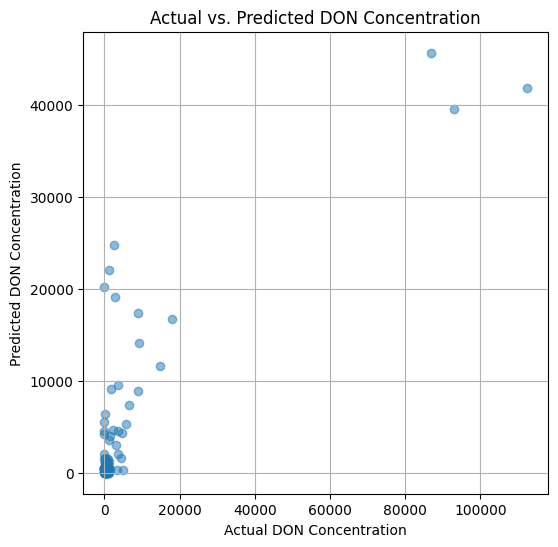

In [ ]:
# Predict on test set
y_pred_nn = model.predict(X_test).flatten()

# Compute metrics
mae_nn = mean_absolute_error(y_test, y_pred_nn)
# Calculate RMSE without using 'squared' parameter
mse_nn = mean_squared_error(y_test, y_pred_nn)  # Calculate MSE
rmse_nn = np.sqrt(mse_nn)  # Calculate RMSE from MSE
r2_nn = r2_score(y_test, y_pred_nn)

print("Neural Network Model Performance:")
print(f"MAE: {mae_nn:.4f}, RMSE: {rmse_nn:.4f}, R² Score: {r2_nn:.4f}")

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.grid()
plt.show()

**Model Interpretability using SHAP**

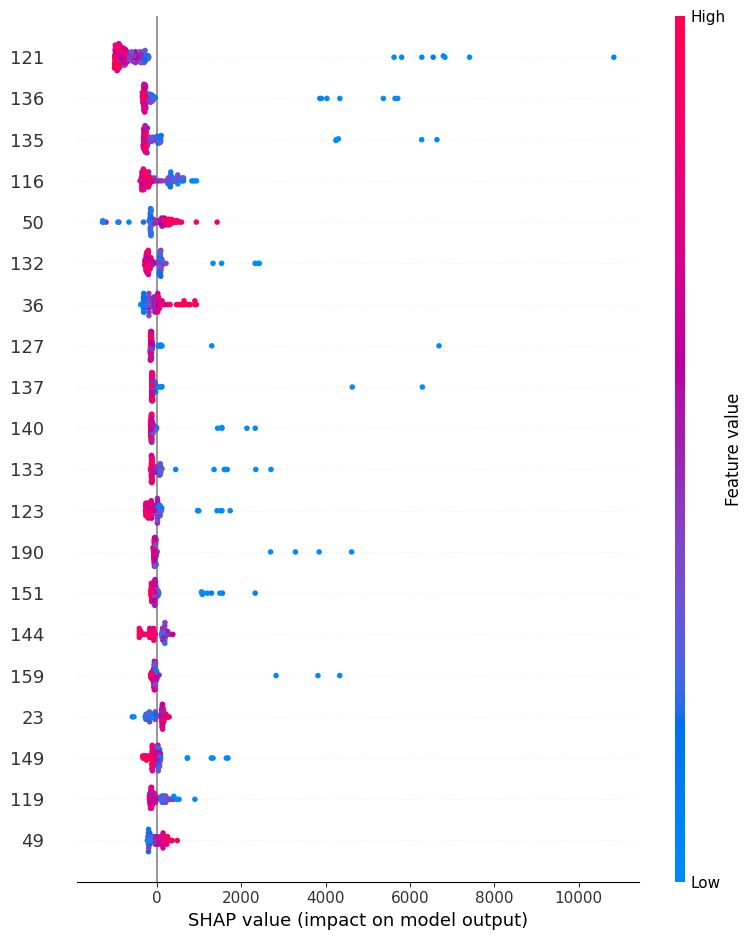

In [ ]:
import shap

# Explain model predictions
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)


**Transformer Model for Regression**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input, Reshape
from tensorflow.keras.models import Model

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # Reshape to (batch_size, seq_len, embed_dim) - for MultiHeadAttention
        # Assuming seq_len = 1 for this case
        inputs = Reshape((1, inputs.shape[-1]))(inputs)

        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        # Reshape back after attention to add with original input
        attn_output = Reshape((attn_output.shape[-1],))(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer Model
def build_transformer(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation="relu")(inputs)
    # Pass training=True or training=False to the call method
    x = TransformerBlock(embed_dim=64, num_heads=2, ff_dim=128)(x, training=True)  # Set to True for training
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model

# Compile and train the transformer model
transformer_model = build_transformer(X_train.shape[1])
transformer_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = transformer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 113824984.0000 - mae: 2569.9099 - val_loss: 298889824.0000 - val_mae: 4403.8008
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 127271184.0000 - mae: 2901.3413 - val_loss: 298824768.0000 - val_mae: 4398.9023
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 158819968.0000 - mae: 3260.3435 - val_loss: 298743904.0000 - val_mae: 4392.8086
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 149753728.0000 - mae: 2771.6541 - val_loss: 298650880.0000 - val_mae: 4385.7983
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 197258176.0000 - mae: 4244.1567 - val_loss: 298526528.0000 - val_mae: 4376.3945
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 169937328.0000 - mae: 3312.4609 - val_loss: 298382560.0000 - val_mae: 4365.4805
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 63452672.0000 - mae: 2512.1021 - val_loss: 298216768.0000 - val_mae: 4353.0640
Epoch 8/50
25/25 ━━━━━━━━━━━

**Ensemble Methods (Stacking)**

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR(kernel='rbf'))
]

# Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Train stacking model
stacking_model.fit(X_train, y_train)

# Predict
y_pred_stack = stacking_model.predict(X_test)

# Evaluate
mae_stack = mean_absolute_error(y_test, y_pred_stack)
print("Stacking Model MAE:", mae_stack)

Stacking Model MAE: 4503.744217102362
